In [36]:
# Initial imports
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from pprint import pprint
import psycopg2
from psycopg2 import sql

#Spark imports
!wget -q https://dlcdn.apache.org/spark/spark-3.5.0/spark-3.5.0-bin-hadoop3.tgz
!tar xf spark-3.5.0-bin-hadoop3.tgz
!pip install -q findspark
!pip install pyspark
!pip install py4j
import os
import sys


# Start a SparkSession
import findspark
findspark.init()


# Amazon SageMaker and related imports
import sagemaker
import sagemaker.amazon.common as smac
from sagemaker.deserializers import JSONDeserializer
from sagemaker.serializers import CSVSerializer
from sagemaker import get_execution_role
from sagemaker import image_uris
import boto3  # AWS Python sdk

%matplotlib inline

In [37]:
# Import packages
from pyspark.sql import SparkSession
# Import the time module so we can time our queries.
import time
# Create a SparkSession
spark = SparkSession.builder.appName("SparkSQL").config("spark.driver.memory", "2g").getOrCreate()

In [38]:
# Read in data from S3 Bucket
from pyspark import SparkFiles
url = "https://aws-project-4.s3.ca-central-1.amazonaws.com/heart_attack_prediction_dataset.csv"
spark.sparkContext.addFile(url)
df = spark.read.csv(SparkFiles.get("heart_attack_prediction_dataset.csv"), sep=",", header=True)
df.show()

24/02/07 03:38:18 WARN SparkContext: The path https://aws-project-4.s3.ca-central-1.amazonaws.com/heart_attack_prediction_dataset.csv has been added already. Overwriting of added paths is not supported in the current version.
+----------+---+------+-----------+--------------+----------+--------+--------------+-------+-------+-------------------+-----------------------+---------+-----------------------+--------------+------------+-----------------------+------+------------------+-------------+-------------------------------+-------------------+-------------+-------------+-------------------+-----------------+
|Patient ID|Age|   Sex|Cholesterol|Blood Pressure|Heart Rate|Diabetes|Family History|Smoking|Obesity|Alcohol Consumption|Exercise Hours Per Week|     Diet|Previous Heart Problems|Medication Use|Stress Level|Sedentary Hours Per Day|Income|               BMI|Triglycerides|Physical Activity Days Per Week|Sleep Hours Per Day|      Country|    Continent|         Hemisphere|Heart Attack 

In [39]:
# Convert PySpark DataFrame to Pandas DataFrame for display options
pd_df_1 = df.toPandas()

# Set display options
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)
pd.set_option("display.precision", 2)

# Display the DataFrame
pd_df_1[:5]

,Patient ID,Age,Sex,Cholesterol,Blood Pressure,Heart Rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,Previous Heart Problems,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Country,Continent,Hemisphere,Heart Attack Risk
0,BMW7812,67,Male,208,158/88,72,0,0,1,0,0,4.168188835442079,Average,0,0,9,6.6150014529140595,261404,31.251232725295402,286,0,6,Argentina,South America,Southern Hemisphere,0
1,CZE1114,21,Male,389,165/93,98,1,1,1,1,1,1.8132416178634458,Unhealthy,1,0,1,4.963458839757678,285768,27.1949733519874,235,1,7,Canada,North America,Northern Hemisphere,0
2,BNI9906,21,Female,324,174/99,72,1,0,0,0,0,2.0783529861178884,Healthy,1,1,9,9.463425838029828,235282,28.176570683909873,587,4,4,France,Europe,Northern Hemisphere,0
3,JLN3497,84,Male,383,163/100,73,1,1,1,0,1,9.82812959348533,Average,1,0,9,7.648980824461007,125640,36.464704293082846,378,3,4,Canada,North America,Northern Hemisphere,0
4,GFO8847,66,Male,318,91/88,93,1,1,1,1,0,5.804298820315434,Unhealthy,1,0,6,1.5148209264291386,160555,21.809144180619754,231,1,5,Thailand,Asia,Northern Hemisphere,0


In [40]:
#Info for the connection wiht postgres SQL in RDS
PGEND_POINT = 'database-1.cfwmkaw8o6bp.us-east-1.rds.amazonaws.com' #End Point
PGDATABASE_NAME ='heart_attack_prediction_db' #data base name 
PGUSER_NAME = 'postgres'
PGPASSWORD = 'B00TC4MP'

In [41]:
#Defining functions for connection and close connection

def connect():
    conn_string = f"host={PGEND_POINT} port=5432 dbname={PGDATABASE_NAME} user={PGUSER_NAME} password={PGPASSWORD}"
    conn = psycopg2.connect(conn_string)
    print("Connected!")
    
    #Create a cursor object
    cursor = conn.cursor()
    
    return conn, cursor

#Close connection function definition
def close_connection(conn, cursor):
    conn.commit()
    cursor.close()
    conn.close()
    print("Connection closed.")

In [42]:
#Creting the connection with postgres SQL
conn, cursor = connect()

Connected!


In [43]:
 #SQL SELECT statement that retrieves all columns (*) from the table named heartattackprediction.
query_hat_all = sql.SQL("""
SELECT * FROM heartattackprediction;
""")

In [44]:
#Preparation of the database cursor to execute the SQL query specified by query_hat_all. 
#Once the query is executed, the cursor will hold the result set (if any) 
#returned by the database server.
cur = conn.cursor()
cur.execute(query_hat_all)

In [45]:
#put all the data in heartattackprediction table into a data frame in pandas all the columns name appear
pd_df = pd.DataFrame(cur.fetchall(), columns=['Patient ID', 'Age', 'Sex','Cholesterol', 'Blood Pressure','Heart Rate','Diabetes','Family History','Smoking','Obesity','Alcohol Consumption','Exercise Hours Per Week','Diet','Previous Heart Problems','Medication Use','Stress Level','Sedentary Hours Per Day','Income','BMI','Triglycerides','Physical Activity Days Per Week','Sleep Hours Per Day','Country','Continent','Hemisphere','Heart Attack Risk'])
pd_df[:5]

,Patient ID,Age,Sex,Cholesterol,Blood Pressure,Heart Rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,Previous Heart Problems,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Country,Continent,Hemisphere,Heart Attack Risk
0,BMW7812,67,Male,208,158/88,72,0,0,1,0,0,4.17,Average,0,0,9,6.62,261404,31.25,286,0,6,Argentina,South America,Southern Hemisphere,0
1,CZE1114,21,Male,389,165/93,98,1,1,1,1,1,1.81,Unhealthy,1,0,1,4.96,285768,27.19,235,1,7,Canada,North America,Northern Hemisphere,0
2,BNI9906,21,Female,324,174/99,72,1,0,0,0,0,2.08,Healthy,1,1,9,9.46,235282,28.18,587,4,4,France,Europe,Northern Hemisphere,0
3,JLN3497,84,Male,383,163/100,73,1,1,1,0,1,9.83,Average,1,0,9,7.65,125640,36.46,378,3,4,Canada,North America,Northern Hemisphere,0
4,GFO8847,66,Male,318,91/88,93,1,1,1,1,0,5.80,Unhealthy,1,0,6,1.51,160555,21.81,231,1,5,Thailand,Asia,Northern Hemisphere,0


In [46]:
pd_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8763 entries, 0 to 8762
Data columns (total 26 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Patient ID                       8763 non-null   object 
 1   Age                              8763 non-null   int64  
 2   Sex                              8763 non-null   object 
 3   Cholesterol                      8763 non-null   int64  
 4   Blood Pressure                   8763 non-null   object 
 5   Heart Rate                       8763 non-null   int64  
 6   Diabetes                         8763 non-null   int64  
 7   Family History                   8763 non-null   int64  
 8   Smoking                          8763 non-null   int64  
 9   Obesity                          8763 non-null   int64  
 10  Alcohol Consumption              8763 non-null   int64  
 11  Exercise Hours Per Week          8763 non-null   float64
 12  Diet                

In [47]:
# Split the "Blood Pressure" column into two separate columns for systolic and diastolic pressure
pd_df[['Systolic Pressure', 'Diastolic Pressure']] = pd_df['Blood Pressure'].str.split('/', expand=True)

# Convert the new columns to numeric
pd_df['Systolic Pressure'] = pd.to_numeric(pd_df['Systolic Pressure'])
pd_df['Diastolic Pressure'] = pd.to_numeric(pd_df['Diastolic Pressure'])

# Drop the original "Blood Pressure" column
pd_df.drop('Blood Pressure', axis=1, inplace=True)

pd_df.columns

Index(['Patient ID', 'Age', 'Sex', 'Cholesterol', 'Heart Rate', 'Diabetes',
       'Family History', 'Smoking', 'Obesity', 'Alcohol Consumption',
       'Exercise Hours Per Week', 'Diet', 'Previous Heart Problems',
       'Medication Use', 'Stress Level', 'Sedentary Hours Per Day', 'Income',
       'BMI', 'Triglycerides', 'Physical Activity Days Per Week',
       'Sleep Hours Per Day', 'Country', 'Continent', 'Hemisphere',
       'Heart Attack Risk', 'Systolic Pressure', 'Diastolic Pressure'],
      dtype='object')

In [48]:
# Dictionary mapping values in the 'gender' column to new values
mapping = {'Female':0,'Male':1,
           'Northern Hemisphere':0, 'Southern Hemisphere':1}

# Use the 'map' method to change the values in the 'gender' column
pd_df['Sex'] = pd_df['Sex'].map(mapping)
pd_df['Hemisphere'] = pd_df['Hemisphere'].map(mapping)

# Show DataFrame
pd_df[:5]

,Patient ID,Age,Sex,Cholesterol,Heart Rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,Previous Heart Problems,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Country,Continent,Hemisphere,Heart Attack Risk,Systolic Pressure,Diastolic Pressure
0,BMW7812,67,1,208,72,0,0,1,0,0,4.17,Average,0,0,9,6.62,261404,31.25,286,0,6,Argentina,South America,1,0,158,88
1,CZE1114,21,1,389,98,1,1,1,1,1,1.81,Unhealthy,1,0,1,4.96,285768,27.19,235,1,7,Canada,North America,0,0,165,93
2,BNI9906,21,0,324,72,1,0,0,0,0,2.08,Healthy,1,1,9,9.46,235282,28.18,587,4,4,France,Europe,0,0,174,99
3,JLN3497,84,1,383,73,1,1,1,0,1,9.83,Average,1,0,9,7.65,125640,36.46,378,3,4,Canada,North America,0,0,163,100
4,GFO8847,66,1,318,93,1,1,1,1,0,5.80,Unhealthy,1,0,6,1.51,160555,21.81,231,1,5,Thailand,Asia,0,0,91,88


In [49]:
# Define categorical features
categorical_features = ['Country', 'Continent', 'Diet'] 
categorical_dummies = pd.get_dummies(pd_df[categorical_features])
categorical_dummies[:5]

,Country_Argentina,Country_Australia,Country_Brazil,Country_Canada,Country_China,Country_Colombia,Country_France,Country_Germany,Country_India,Country_Italy,Country_Japan,Country_New Zealand,Country_Nigeria,Country_South Africa,Country_South Korea,Country_Spain,Country_Thailand,Country_United Kingdom,Country_United States,Country_Vietnam,Continent_Africa,Continent_Asia,Continent_Australia,Continent_Europe,Continent_North America,Continent_South America,Diet_Average,Diet_Healthy,Diet_Unhealthy
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1


In [50]:
# Check unique values for each column
for col in pd_df.columns:
    print(f"Unique values for column '{col}': {pd_df[col].unique()}")


Unique values for column 'Patient ID': ['BMW7812' 'CZE1114' 'BNI9906' ... 'XKA5925' 'EPE6801' 'ZWN9666']
Unique values for column 'Age': [67 21 84 66 54 90 20 43 73 71 77 60 88 69 38 50 45 36 48 40 79 63 27 25
 86 42 52 29 30 47 44 33 51 70 85 31 56 24 74 72 55 26 53 46 57 22 35 39
 80 65 83 82 28 19 75 18 34 37 89 32 49 23 59 62 64 61 76 41 87 81 58 78
 68]
Unique values for column 'Sex': [1 0]
Unique values for column 'Cholesterol': [208 389 324 383 318 297 358 220 145 248 373 374 228 259 122 379 166 303
 340 294 359 202 133 159 271 273 328 154 135 197 321 375 360 263 201 347
 129 229 251 121 190 185 279 336 192 180 203 368 222 243 218 120 285 377
 369 311 139 266 153 339 329 333 398 124 183 163 362 390 200 396 255 209
 247 250 227 246 223 330 195 194 178 155 240 237 216 276 224 326 198 301
 314 304 334 213 254 230 316 277 388 206 384 205 261 308 338 382 291 168
 171 378 253 245 226 281 123 173 231 234 268 306 186 293 161 380 239 149
 320 219 335 265 126 307 270 225 193 148 296 136 3

In [51]:
# Define numerical features
numerical_features = [col for col in pd_df.columns if col not in ['Patient ID','Heart Attack Risk'] + categorical_features]

In [52]:
encoded_df = pd.concat([pd_df.drop(categorical_features, axis=1), categorical_dummies], axis=1)
encoded_df['Patient ID'] = pd_df['Patient ID']
encoded_df = encoded_df.set_index('Patient ID')
encoded_df[:5]

,Age,Sex,Cholesterol,Heart Rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Previous Heart Problems,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Hemisphere,Heart Attack Risk,Systolic Pressure,Diastolic Pressure,Country_Argentina,Country_Australia,Country_Brazil,Country_Canada,Country_China,Country_Colombia,Country_France,Country_Germany,Country_India,Country_Italy,Country_Japan,Country_New Zealand,Country_Nigeria,Country_South Africa,Country_South Korea,Country_Spain,Country_Thailand,Country_United Kingdom,Country_United States,Country_Vietnam,Continent_Africa,Continent_Asia,Continent_Australia,Continent_Europe,Continent_North America,Continent_South America,Diet_Average,Diet_Healthy,Diet_Unhealthy
Patient ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
BMW7812,67,1,208,72,0,0,1,0,0,4.17,0,0,9,6.62,261404,31.25,286,0,6,1,0,158,88,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
CZE1114,21,1,389,98,1,1,1,1,1,1.81,1,0,1,4.96,285768,27.19,235,1,7,0,0,165,93,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
BNI9906,21,0,324,72,1,0,0,0,0,2.08,1,1,9,9.46,235282,28.18,587,4,4,0,0,174,99,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
JLN3497,84,1,383,73,1,1,1,0,1,9.83,1,0,9,7.65,125640,36.46,378,3,4,0,0,163,100,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
GFO8847,66,1,318,93,1,1,1,1,0,5.80,1,0,6,1.51,160555,21.81,231,1,5,0,0,91,88,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1


In [53]:
encoded_df.shape

(8763, 52)

In [54]:
encoded_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8763 entries, BMW7812 to ZWN9666
Data columns (total 52 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Age                              8763 non-null   int64  
 1   Sex                              8763 non-null   int64  
 2   Cholesterol                      8763 non-null   int64  
 3   Heart Rate                       8763 non-null   int64  
 4   Diabetes                         8763 non-null   int64  
 5   Family History                   8763 non-null   int64  
 6   Smoking                          8763 non-null   int64  
 7   Obesity                          8763 non-null   int64  
 8   Alcohol Consumption              8763 non-null   int64  
 9   Exercise Hours Per Week          8763 non-null   float64
 10  Previous Heart Problems          8763 non-null   int64  
 11  Medication Use                   8763 non-null   int64  
 12  Stress Level    

In [55]:
# Convert columns to appropriate data types
encoded_df['Age'] = encoded_df['Age'].astype(int)
encoded_df['Cholesterol'] = encoded_df['Cholesterol'].astype(int)
encoded_df['Heart Rate'] = encoded_df['Heart Rate'].astype(int)
encoded_df['Diabetes'] = encoded_df['Diabetes'].astype(int)
encoded_df['Family History'] = encoded_df['Family History'].astype(int)
encoded_df['Smoking'] = encoded_df['Smoking'].astype(int)
encoded_df['Obesity'] = encoded_df['Obesity'].astype(int)
encoded_df['Alcohol Consumption'] = encoded_df['Alcohol Consumption'].astype(int)
encoded_df['Exercise Hours Per Week'] = encoded_df['Exercise Hours Per Week'].astype(float)
encoded_df['Previous Heart Problems'] = encoded_df['Previous Heart Problems'].astype(int)
encoded_df['Medication Use'] = encoded_df['Medication Use'].astype(int)
encoded_df['Stress Level'] = encoded_df['Stress Level'].astype(int)
encoded_df['Sedentary Hours Per Day'] = encoded_df['Sedentary Hours Per Day'].astype(float)
encoded_df['Income'] = encoded_df['Income'].astype(int)
encoded_df['BMI'] = encoded_df['BMI'].astype(float)
encoded_df['Triglycerides'] = encoded_df['Triglycerides'].astype(int)
encoded_df['Physical Activity Days Per Week'] = encoded_df['Physical Activity Days Per Week'].astype(int)
encoded_df['Sleep Hours Per Day'] = encoded_df['Sleep Hours Per Day'].astype(int)
encoded_df['Heart Attack Risk'] = encoded_df['Heart Attack Risk'].astype(int)

# Print the data types of all columns
print(encoded_df.dtypes)


Age                                  int64
Sex                                  int64
Cholesterol                          int64
Heart Rate                           int64
Diabetes                             int64
Family History                       int64
Smoking                              int64
Obesity                              int64
Alcohol Consumption                  int64
Exercise Hours Per Week            float64
Previous Heart Problems              int64
Medication Use                       int64
Stress Level                         int64
Sedentary Hours Per Day            float64
Income                               int64
BMI                                float64
Triglycerides                        int64
Physical Activity Days Per Week      int64
Sleep Hours Per Day                  int64
Hemisphere                           int64
Heart Attack Risk                    int64
Systolic Pressure                    int64
Diastolic Pressure                   int64
Country_Arg

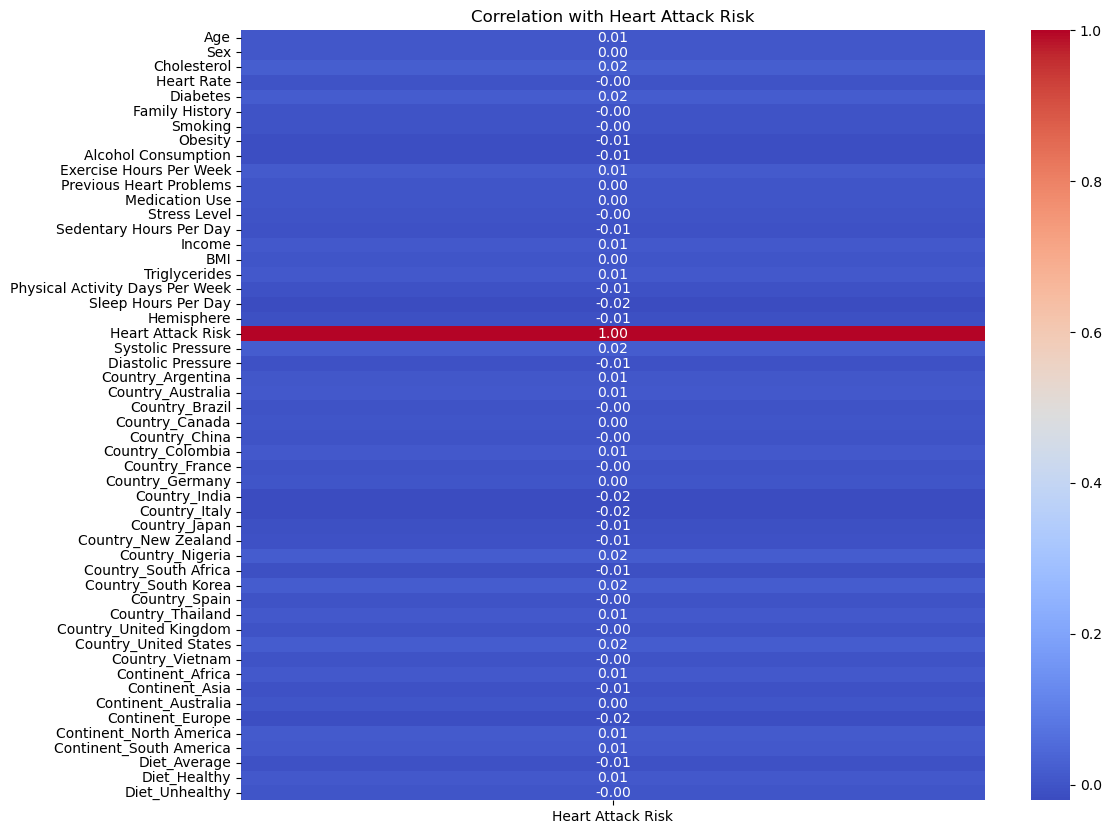

In [56]:
# Compute the correlation matrix
correlation_matrix = encoded_df.corr()

import seaborn as sns
import matplotlib.pyplot as plt

# Visualize it using a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix[['Heart Attack Risk']], annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation with Heart Attack Risk")
plt.show()


In [57]:
encoded_df.columns

Index(['Age', 'Sex', 'Cholesterol', 'Heart Rate', 'Diabetes', 'Family History',
       'Smoking', 'Obesity', 'Alcohol Consumption', 'Exercise Hours Per Week',
       'Previous Heart Problems', 'Medication Use', 'Stress Level',
       'Sedentary Hours Per Day', 'Income', 'BMI', 'Triglycerides',
       'Physical Activity Days Per Week', 'Sleep Hours Per Day', 'Hemisphere',
       'Heart Attack Risk', 'Systolic Pressure', 'Diastolic Pressure',
       'Country_Argentina', 'Country_Australia', 'Country_Brazil',
       'Country_Canada', 'Country_China', 'Country_Colombia', 'Country_France',
       'Country_Germany', 'Country_India', 'Country_Italy', 'Country_Japan',
       'Country_New Zealand', 'Country_Nigeria', 'Country_South Africa',
       'Country_South Korea', 'Country_Spain', 'Country_Thailand',
       'Country_United Kingdom', 'Country_United States', 'Country_Vietnam',
       'Continent_Africa', 'Continent_Asia', 'Continent_Australia',
       'Continent_Europe', 'Continent_North Am

In [58]:
# Save encoded_df as a JSON file with records orientation
encoded_df.to_json("https://aws-project-4.s3.ca-central-1.amazonaws.com/encoded_df.json")

# Separate features and target variable

In [59]:
X = encoded_df.drop(['Exercise Hours Per Week',
     'Stress Level',
       'Sedentary Hours Per Day', 'Income', 
       'Physical Activity Days Per Week', 'Sleep Hours Per Day', 'Hemisphere',
       'Heart Attack Risk',
       'Country_Argentina', 'Country_Australia', 'Country_Brazil',
       'Country_Canada', 'Country_China', 'Country_Colombia', 'Country_France',
       'Country_Germany', 'Country_India', 'Country_Italy', 'Country_Japan',
       'Country_New Zealand', 'Country_Nigeria', 'Country_South Africa',
       'Country_South Korea', 'Country_Spain', 'Country_Thailand',
       'Country_United Kingdom', 'Country_United States', 'Country_Vietnam',
       'Continent_Africa', 'Continent_Asia', 'Continent_Australia',
       'Continent_Europe', 'Continent_North America',
       'Continent_South America', 'Diet_Average', 'Diet_Healthy',
       'Diet_Unhealthy'], axis=1)
y = encoded_df['Heart Attack Risk']

# Split the data into training and testing sets

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [61]:
# Creating StandardScaler instance
scaler = StandardScaler()

In [62]:
# Fitting Standard Scaller
X_scaler = scaler.fit(X_train)

In [63]:
# Scaling data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [64]:
# Create a random forest classifier
rf_model = RandomForestClassifier(n_estimators=300, random_state=78)

In [65]:
# Fit the model and use .ravel()on the "y_train" data. 
rf_model = rf_model.fit(X_train_scaled, y_train)

In [66]:
# Making predictions using the testing data
rf_predictions = rf_model.predict(X_test_scaled)

In [67]:
print(f"Training Data Score: {rf_model.score(X_train_scaled, y_train)}")
print(f"Testing Data Score: {rf_model.score(X_test_scaled, y_test)}")

Training Data Score: 1.0
Testing Data Score: 0.6280661722760981


In [68]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, rf_predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, rf_predictions)

In [69]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, rf_predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,1090,35
Actual 1,617,11


Accuracy Score : 0.6280661722760981
Classification Report
              precision    recall  f1-score   support

           0       0.64      0.97      0.77      1125
           1       0.24      0.02      0.03       628

    accuracy                           0.63      1753
   macro avg       0.44      0.49      0.40      1753
weighted avg       0.50      0.63      0.51      1753



In [70]:
# Get the feature importance array
importances = rf_model.feature_importances_

# List the top 10 most important features
importances_top_10 = sorted(zip(importances, X.columns), reverse=True)[:10]
print("Top 10 most important features:")
pprint(importances_top_10)

Top 10 most important features:
[(0.13664973096325633, 'BMI'),
 (0.1321089192820995, 'Triglycerides'),
 (0.1296970617175235, 'Cholesterol'),
 (0.12088277645102209, 'Systolic Pressure'),
 (0.11658911091247082, 'Age'),
 (0.11602031049161496, 'Heart Rate'),
 (0.11052030388867727, 'Diastolic Pressure'),
 (0.020187810862671837, 'Previous Heart Problems'),
 (0.02002846328353375, 'Medication Use'),
 (0.01963319871353625, 'Alcohol Consumption')]


# KNN model

In [71]:
X = encoded_df.drop(['Exercise Hours Per Week',
     'Stress Level',
       'Sedentary Hours Per Day', 'Income', 
       'Physical Activity Days Per Week', 'Sleep Hours Per Day', 'Hemisphere',
       'Heart Attack Risk',
       'Country_Argentina', 'Country_Australia', 'Country_Brazil',
       'Country_Canada', 'Country_China', 'Country_Colombia', 'Country_France',
       'Country_Germany', 'Country_India', 'Country_Italy', 'Country_Japan',
       'Country_New Zealand', 'Country_Nigeria', 'Country_South Africa',
       'Country_South Korea', 'Country_Spain', 'Country_Thailand',
       'Country_United Kingdom', 'Country_United States', 'Country_Vietnam',
       'Continent_Africa', 'Continent_Asia', 'Continent_Australia',
       'Continent_Europe', 'Continent_North America',
       'Continent_South America', 'Diet_Average', 'Diet_Healthy',
       'Diet_Unhealthy'], axis=1)
y = encoded_df['Heart Attack Risk']

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [73]:
# Creating StandardScaler instance
scaler = StandardScaler()

In [74]:
# Fitting Standard Scaller
X_scaler = scaler.fit(X_train)

In [75]:
# Scaling data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [76]:
from sklearn.neighbors import KNeighborsClassifier
# Instantiate the model with k = 3 neighbors
knn_model = KNeighborsClassifier(n_neighbors=50)

# Train the model
knn_model.fit(X_train_scaled, y_train)
# Create predictions
knn_y_pred = knn_model.predict(X_test_scaled)

In [77]:
print(f"Training Data Score: {knn_model.score(X_train_scaled, y_train)}")
print(f"Testing Data Score: {knn_model.score(X_test_scaled, y_test)}")

Training Data Score: 0.6412268188302425
Testing Data Score: 0.6400456360524814


In [78]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, knn_y_pred)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, knn_y_pred)

In [79]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test,  knn_y_pred))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,1116,9
Actual 1,622,6


Accuracy Score : 0.6400456360524814
Classification Report
              precision    recall  f1-score   support

           0       0.64      0.99      0.78      1125
           1       0.40      0.01      0.02       628

    accuracy                           0.64      1753
   macro avg       0.52      0.50      0.40      1753
weighted avg       0.56      0.64      0.51      1753



# SVC model

In [80]:
X = encoded_df.drop(['Exercise Hours Per Week',
     'Stress Level',
       'Sedentary Hours Per Day', 'Income', 
       'Physical Activity Days Per Week', 'Sleep Hours Per Day', 'Hemisphere',
       'Heart Attack Risk',
       'Country_Argentina', 'Country_Australia', 'Country_Brazil',
       'Country_Canada', 'Country_China', 'Country_Colombia', 'Country_France',
       'Country_Germany', 'Country_India', 'Country_Italy', 'Country_Japan',
       'Country_New Zealand', 'Country_Nigeria', 'Country_South Africa',
       'Country_South Korea', 'Country_Spain', 'Country_Thailand',
       'Country_United Kingdom', 'Country_United States', 'Country_Vietnam',
       'Continent_Africa', 'Continent_Asia', 'Continent_Australia',
       'Continent_Europe', 'Continent_North America',
       'Continent_South America', 'Diet_Average', 'Diet_Healthy',
       'Diet_Unhealthy'], axis=1)
y = encoded_df['Heart Attack Risk']

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [82]:
from sklearn.svm import SVC 
SVC_model = SVC(kernel='linear')
SVC_model.fit(X_train, y_train)

SVC(kernel='linear')

In [83]:
SVC_predictions = SVC_model.predict(X_test)

In [84]:
print(f"Training Data Score: {SVC_model.score(X_train, y_train)}")
print(f"Testing Data Score: {SVC_model.score(X_test, y_test)}")

Training Data Score: 0.6417974322396577
Testing Data Score: 0.6417569880205363


In [85]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, SVC_predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, SVC_predictions)

In [86]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test,  SVC_predictions))


Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,1125,0
Actual 1,628,0


Accuracy Score : 0.6417569880205363
Classification Report
              precision    recall  f1-score   support

           0       0.64      1.00      0.78      1125
           1       0.00      0.00      0.00       628

    accuracy                           0.64      1753
   macro avg       0.32      0.50      0.39      1753
weighted avg       0.41      0.64      0.50      1753



/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

# LogisticRegression

In [87]:
y = encoded_df['Heart Attack Risk']
X = encoded_df.drop(['Exercise Hours Per Week',
     'Stress Level',
       'Sedentary Hours Per Day', 'Income', 
       'Physical Activity Days Per Week', 'Sleep Hours Per Day', 'Hemisphere',
       'Heart Attack Risk',
       'Country_Argentina', 'Country_Australia', 'Country_Brazil',
       'Country_Canada', 'Country_China', 'Country_Colombia', 'Country_France',
       'Country_Germany', 'Country_India', 'Country_Italy', 'Country_Japan',
       'Country_New Zealand', 'Country_Nigeria', 'Country_South Africa',
       'Country_South Korea', 'Country_Spain', 'Country_Thailand',
       'Country_United Kingdom', 'Country_United States', 'Country_Vietnam',
       'Continent_Africa', 'Continent_Asia', 'Continent_Australia',
       'Continent_Europe', 'Continent_North America',
       'Continent_South America', 'Diet_Average', 'Diet_Healthy',
       'Diet_Unhealthy'], axis=1)

In [88]:
#balance labels y
balance_labels = y.value_counts()
balance_labels

0    5624
1    3139
Name: Heart Attack Risk, dtype: int64

There seems to be a bit of imbalance, with more instances of 
class 0 compared to class 1. Depending on our model's sensitivity to class 
imbalances, we may want to consider techniques like (1) oversampling, 
(2) undersampling, or (3) using class weights during model training to handle this imbalance.

In [89]:
# Split the data using train_test_split
# Assign a random_state of 1 to the function

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train.shape

(7010, 15)

7010: This is the number of samples or instances in your training set. Each row represents a separate observation or data point in your dataset.

26: This is the number of features or variables in your dataset. Each column in your dataset corresponds to a different feature or attribute that is used for training your machine learning model.

So, in summary, you have 7010 training samples, and each sample has 26 features. This information is crucial for understanding the dimensions of your training data, especially when you're working with machine learning models that require input of specific shapes.

In [90]:
# Import the LogisticRegression module from SKLearn
from sklearn.linear_model import LogisticRegression

# Instantiate the Logistic Regression model
# Assign a random_state parameter of 1 to the model
logistic_model = LogisticRegression(solver="lbfgs",max_iter=200, random_state=1)

In [91]:
# Fit the model using training data
logistic_model.fit(X_train, y_train)

/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=200, random_state=1)

In [92]:
print(f"Training Data Score: {logistic_model.score(X_train, y_train)}")
print(f"Testing Data Score: {logistic_model.score(X_test, y_test)}")

Training Data Score: 0.6393723252496434
Testing Data Score: 0.6514546491728466


In [93]:
# Make a prediction using the testing data
lr_predictions = logistic_model.predict(X_test)
results = pd.DataFrame({"Prediction": lr_predictions, "Actual": y_test}).reset_index(drop = True)
results.head(10)

,Prediction,Actual
0,0,1
1,0,0
2,0,0
3,0,1
4,0,1
5,0,0
6,0,1
7,0,0
8,0,1
9,0,1


In [94]:
accuracy_score(y_test, lr_predictions)

0.6514546491728466

### Evaluation of the model’s performance by doing the following:

* Calculate the accuracy score of the model.

* Generate a confusion matrix.

* Print the classification report.

In [95]:
balanced_accuracy = accuracy_score(y_test, lr_predictions)
balanced_accuracy

0.6514546491728466

In [96]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, lr_predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, lr_predictions)

In [97]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test,  lr_predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,1142,0
Actual 1,611,0


Accuracy Score : 0.6514546491728466
Classification Report
              precision    recall  f1-score   support

           0       0.65      1.00      0.79      1142
           1       0.00      0.00      0.00       611

    accuracy                           0.65      1753
   macro avg       0.33      0.50      0.39      1753
weighted avg       0.42      0.65      0.51      1753



/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

Let's break down what each of these means:

True Negative (TN): 18673 instances were correctly predicted as class 0 (negative class).

False Positive (FP): 86 instances were incorrectly predicted as class 1 (positive class) when they were actually class 0.

False Negative (FN): 32 instances were incorrectly predicted as class 0 when they were actually class 1.

True Positive (TP): 593 instances were correctly predicted as class 1.

Precision: Precision is the ratio of correctly predicted positive observations to the total predicted positives. In your case:

Precision for class 0: 0.65 (65% of instances predicted as class 0 were actually class 0)
Precision for class 1: 0.00 (None of the instances predicted as class 1 were actually class 1)
Recall (Sensitivity): Recall is the ratio of correctly predicted positive observations to the all observations in actual class. In your case:

Recall for class 0: 1.00 (All instances of class 0 were correctly predicted)
Recall for class 1: 0.00 (None of the instances of class 1 were correctly predicted)
F1-Score: F1-Score is the weighted average of Precision and Recall. It is a balance between precision and recall. In your case:

F1-Score for class 0: 0.79 (Weighted average of precision and recall for class 0)
F1-Score for class 1: 0.00 (Weighted average of precision and recall for class 1)
Support: The number of actual occurrences of each class in the specified dataset. In your case:

Support for class 0: 1142 instances
Support for class 1: 611 instances
Accuracy: Overall accuracy of the model on the testing data. In your case: 0.65 (65%)

Macro Average: The average of precision, recall, and F1-Score for both classes, without considering class imbalance. In your case:

Macro Average Precision: 0.33
Macro Average Recall: 0.50
Macro Average F1-Score: 0.39
Weighted Average: The average of precision, recall, and F1-Score, weighted by the number of samples in each class. In your case:

Weighted Average Precision: 0.42
Weighted Average Recall: 0.65
Weighted Average F1-Score: 0.51
These metrics provide a more nuanced understanding of your model's performance for each class and overall. In this case, it seems that the model is performing well in predicting class 0 but struggling to predict class 1, as indicated by the low recall and F1-Score for class 1. Depending on the specific goals of your model, you may need to adjust the model or data preprocessing to improve its performance.

In [98]:
#Handling Imbalanced Data:

logistic_model = LogisticRegression(class_weight='balanced', random_state=1)

In [99]:
!pip install imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.7/257.7 kB 2.5 MB/s eta 0:00:00a 0:00:01


In [100]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=1)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [101]:
# Instantiate a new logistic regression model
logistic_model_resampled = LogisticRegression(random_state=1)

# Fit the model with the resampled data
logistic_model_resampled.fit(X_resampled, y_resampled)

# Make predictions on the testing data
predictions_resampled = logistic_model_resampled.predict(X_test)

/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [102]:
#Evaluate the performance
accuracy_resampled = accuracy_score(y_test, predictions_resampled)
classification_report_resampled = classification_report(y_test, predictions_resampled)
confusion_matrix_resampled = confusion_matrix(y_test, predictions_resampled)

print("Accuracy (Resampled):", accuracy_resampled)
print("Classification Report (Resampled):\n", classification_report_resampled)
print("Confusion Matrix (Resampled):\n", confusion_matrix_resampled)

Accuracy (Resampled): 0.5339418140330862
Classification Report (Resampled):
               precision    recall  f1-score   support

           0       0.65      0.61      0.63      1142
           1       0.35      0.38      0.37       611

    accuracy                           0.53      1753
   macro avg       0.50      0.50      0.50      1753
weighted avg       0.55      0.53      0.54      1753

Confusion Matrix (Resampled):
 [[701 441]
 [376 235]]


# GridSearchCV

In [103]:
y = encoded_df['Heart Attack Risk']
X = encoded_df.drop(['Heart Attack Risk'], axis=1)

In [111]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Assuming you already have X and y defined

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating StandardScaler instance
scaler = MinMaxScaler()

# Fitting StandardScaler
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the pipeline including MinMaxScaler and KNeighborsClassifier
knn_pipe = Pipeline([
    ('mms', MinMaxScaler()),
    ('knn', KNeighborsClassifier())
])

# Define the parameters grid for GridSearchCV
params = [{
    'knn__n_neighbors': [3, 5, 7, 9],
    'knn__weights': ['uniform', 'distance'],
    'knn__leaf_size': [15, 20]
}]

# Initialize GridSearchCV with the pipeline, parameters, scoring, and cross-validation
gs_knn = GridSearchCV(
    knn_pipe,
    param_grid=params,
    scoring='accuracy',
    cv=5
)

# Fit GridSearchCV on the training data
gs_knn.fit(X_train_scaled, y_train)

# Print the best parameters found by GridSearchCV
print("Best Parameters:", gs_knn.best_params_)

# Find the score of the best model on the training data
print("Best Model Score on Training Data:", gs_knn.score(X_train_scaled, y_train))
print(f"Training Data Score: {gs_knn.score(X_train_scaled, y_train)}")
print(f"Testing Data Score: {gs_knn.score(X_test_scaled, y_test)}")

Best Parameters: {'knn__leaf_size': 15, 'knn__n_neighbors': 9, 'knn__weights': 'distance'}
Best Model Score on Training Data: 1.0
Training Data Score: 1.0
Testing Data Score: 0.5966913861950941


In [113]:
gs_knn_y_pred = gs_knn.predict(X_test_scaled)

In [114]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, gs_knn_y_pred)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, gs_knn_y_pred)

In [115]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test,  gs_knn_y_pred))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,933,192
Actual 1,515,113


Accuracy Score : 0.5966913861950941
Classification Report
              precision    recall  f1-score   support

           0       0.64      0.83      0.73      1125
           1       0.37      0.18      0.24       628

    accuracy                           0.60      1753
   macro avg       0.51      0.50      0.48      1753
weighted avg       0.55      0.60      0.55      1753



# Grid Search with Logistic Regression

In [105]:
y = encoded_df['Heart Attack Risk']
X = encoded_df.drop(['Heart Attack Risk'], axis=1)

In [106]:
X = (X-np.min(X))/(np.max(X)-np.min(X))

/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)
/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)
/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduct

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [108]:
# Grid search cross validation
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg,grid,cv=10)
logreg_cv.fit(X_train,y_train)

print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.001, 'penalty': 'l2'}
accuracy : 0.6411802370995425


/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
70 fits failed out of a total of 140.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
70 fits failed with the following error:
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10

In [109]:
logreg2=LogisticRegression(C=1,penalty="l2")
logreg2.fit(X_train,y_train)
print("score",logreg2.score(X_test,y_test))

score 0.6435907189045265
